## Loading libraries

In [63]:
# general packages for data manipulation
import sklearn 
import numpy as np
import pandas as pd

# visualizations
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')

# handle and omit warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None 

# display pandas dataframe columns 
pd.options.display.max_columns = None

# Load the sklearn stuff
import sklearn 
print(sklearn.__version__)

# making text data numeric
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

# making numeric data comparable
from sklearn.preprocessing import StandardScaler

# experimental regime and pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# machine learning algorithm
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

# evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# get reproducible results
np.random.seed(42)
#tf.random.set_seed(42)

1.3.0


### 1. Data inspection

In [2]:
OLID_train = pd.read_csv('olid-training-v1.0.tsv', delimiter='\t', encoding='utf-8')
OLID_train.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [3]:
# Check the information of the dataset
OLID_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         13240 non-null  int64 
 1   tweet      13240 non-null  object
 2   subtask_a  13240 non-null  object
 3   subtask_b  4400 non-null   object
 4   subtask_c  3876 non-null   object
dtypes: int64(1), object(4)
memory usage: 517.3+ KB


In [4]:
# rename columns if necessary
OLID_train.rename({'tweet': 'text', 'subtask_a': 'label'}, axis=1, inplace=True) 
# convert label to a numerical/dummy variable and save in a new column
OLID_train['target'] = OLID_train.label.map({'NOT':0, 'OFF':1}) 
# drop irrelevant columns
OLID_train.drop(['subtask_b', 'subtask_c'], axis=1, inplace=True) 

# create a copy of the original data to work with 
df = OLID_train.copy()
df.head()

,id,text,label,target
0,86426,@USER She should ask a few native Americans wh...,OFF,1
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,1
2,16820,Amazon is investigating Chinese employees who ...,NOT,0
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,1
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,0


In [5]:
# Take a look at the tweet
df.text[1]

'@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL'

In [6]:
# check for missing values
df.isnull().sum()

id        0
text      0
label     0
target    0
dtype: int64

In [7]:
# check for duplicates
df.duplicated().sum()

0

In [8]:
# check class distributions 
df_Stat=df[['label','text']].groupby('label').count().reset_index()
df_Stat.columns=['label','count']
df_Stat['percentage']=(df_Stat['count']/df_Stat['count'].sum())*100
df_Stat

,label,count,percentage
0,NOT,8840,66.767372
1,OFF,4400,33.232628


### 2. Data preprocessing

In [9]:
import re # regular expression
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
eng_stops = set(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 

def clean(text):
    # replace URLs with an empty string
#     text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # remove all the special characters
    text = re.sub('[^a-zA-Z]', ' ',text) 
    # convert all letters to lower case
    words = text.lower().split()
    # remove stop words
    words = [w for w in words if not w in eng_stops]    
    # lemmatize all words
    words = [lemmatizer.lemmatize(word) for word in words]
    # join all words back to text
    return (' '.join(words))

df['clean'] = df['text'].apply(lambda x: clean(x))
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bella\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,text,label,target,clean
0,86426,@USER She should ask a few native Americans wh...,OFF,1,user ask native american take
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,1,user user go home drunk user maga trump url
2,16820,Amazon is investigating Chinese employees who ...,NOT,0,amazon investigating chinese employee selling ...
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,1,user someone vetaken piece shit volcano
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,0,user user obama wanted liberal amp illegals mo...


In [10]:
df.text[1]

'@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL'

In [11]:
df.clean[1]

'user user go home drunk user maga trump url'

#### More complicated cases in real life:

<img src="tweets_examples.jpg" />

###### HTML, XML characters:
https://www.htmlhelp.com/reference/html40/entities/special.html

### 3. Split data

###### Since this dataset is already split, we don't have to do this step now. 

In [ ]:
# create a new DataFrame X which includes all columns from df except for the ones named "label" and "target"
from sklearn.model_selection import train_test_split
X = df.drop(columns = ["label", "target"])
y = df[["target"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

### 4. Baseline model

######  SGDclassifier 

(11916, 2) (1324, 2) (11916,) (1324,)
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       884
           1       0.73      0.47      0.58       440

    accuracy                           0.77      1324
   macro avg       0.76      0.69      0.71      1324
weighted avg       0.76      0.77      0.75      1324



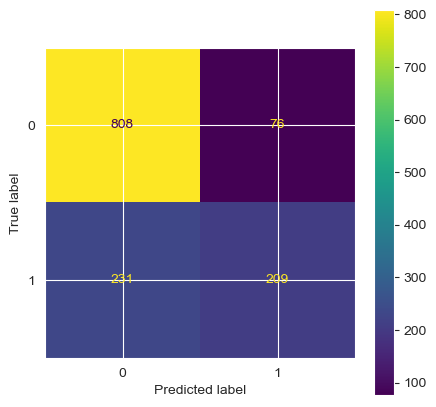

In [12]:
## SGD classifier with tf-idf weighted BoW
X = df.drop(columns=['id', 'label', 'target'])
y = df.target

# Split the training data into training and validation sets

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.10, stratify=y, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

tfidf_vect = TfidfVectorizer(max_features=5000, ngram_range=(1,2), tokenizer= str.split)

# Distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
     (tfidf_vect, 'clean'), # assign Column clean to the vectorizer
    remainder = 'drop') # drop Column text

clf = SGDClassifier(random_state=42)

pipe = make_pipeline(preprocessor,clf)

pipe.fit(X_train, y_train)
y_val_pred = pipe.predict(X_val)

print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax);

### 5. Feature engineering/extraction (create additional features)

###### VADER sentiment analysis

In [13]:
import nltk
nltk.download(['vader_lexicon'])
from nltk.sentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in df['text']]
df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in df['text']]
df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in df['text']]
df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in df['text']]
df.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\bella\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,id,text,label,target,clean,compound,neg,neu,pos
0,86426,@USER She should ask a few native Americans wh...,OFF,1,user ask native american take,0.0000,0.000,1.000,0.00
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,1,user user go home drunk user maga trump url,-0.5067,0.247,0.753,0.00
2,16820,Amazon is investigating Chinese employees who ...,NOT,0,amazon investigating chinese employee selling ...,0.3400,0.000,0.880,0.12
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,1,user someone vetaken piece shit volcano,-0.5574,0.286,0.714,0.00
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,0,user user obama wanted liberal amp illegals mo...,0.0000,0.000,1.000,0.00


### 6. Machine learning models comparison

###### 6.1 SGDClassifier

(11916, 6) (1324, 6) (11916,) (1324,)
              precision    recall  f1-score   support

           0       0.83      0.80      0.81       884
           1       0.62      0.66      0.64       440

    accuracy                           0.75      1324
   macro avg       0.72      0.73      0.73      1324
weighted avg       0.76      0.75      0.75      1324



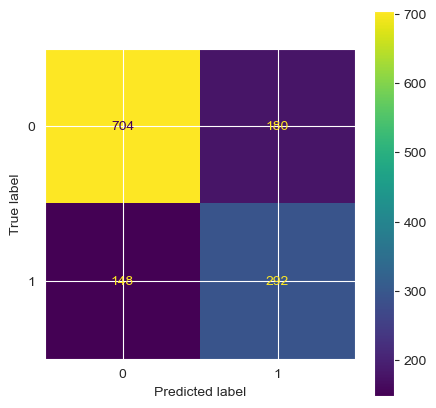

In [14]:
sdg_clf = SGDClassifier(random_state=42, class_weight='balanced') 
# "class_weight='balanced'": 
# If not given, all classes are supposed to have weight one. 
# The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data 
# as [n_samples / (n_classes * np.bincount(y))].

X = df.drop(columns=['id', 'label', 'target'])
y = df.target

# Split data into training, dev and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.10, stratify=y, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# Scale the numerical data so that they are comparible
scaler = StandardScaler()

tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
#tfidf_char = TfidfVectorizer(ngram_range=(2, 2), analyzer='char', stop_words='english')
#count_vect = CountVectorizer(ngram_range=(1, 3), stop_words='english')

# Distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
     (scaler, ['compound', 'neg', 'neu', 'pos']),
     (tfidf_vect, 'clean'),
#     (tfidf_char, 'clean'), # decent results IF lemmatization disabled; otherwise, better left out (cf. count_vect)
    remainder = 'drop')

sdg_pipe = make_pipeline(preprocessor, sdg_clf)

sdg_pipe.fit(X_train, y_train)
y_val_pred = sdg_pipe.predict(X_val)

print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred, labels=sdg_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sdg_pipe.classes_)

fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax);

###### 6.2 Logistic Regression

(11916, 6) (1324, 6) (11916,) (1324,)
              precision    recall  f1-score   support

           0       0.76      0.89      0.82       884
           1       0.67      0.45      0.53       440

    accuracy                           0.74      1324
   macro avg       0.72      0.67      0.68      1324
weighted avg       0.73      0.74      0.73      1324



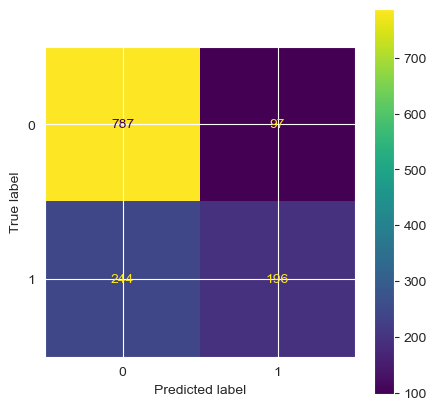

In [15]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(random_state=42, max_iter=1500)

X = df.drop(columns=['id', 'label', 'target'])
y = df.target

# Split data into training, dev and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.10, stratify=y, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

scaler = StandardScaler()

tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
#tfidf_char = TfidfVectorizer(ngram_range=(2, 2), analyzer='char', stop_words='english')
#count_vect = CountVectorizer(ngram_range=(1, 3), stop_words='english')

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
     (scaler, ['compound', 'neg', 'neu', 'pos']), # we scale numeric features
     (tfidf_vect, 'clean'),
#     (tfidf_char, 'clean'),
    remainder = 'drop')

log_pipe = make_pipeline(preprocessor, log_clf)

log_pipe.fit(X_train, y_train)
y_val_pred = log_pipe.predict(X_val)

print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred, labels=log_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_pipe.classes_)

fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax);

#### 6.3 Decision Tree

(11916, 6) (1324, 6) (11916,) (1324,)
              precision    recall  f1-score   support

           0       0.80      0.72      0.75       884
           1       0.53      0.64      0.58       440

    accuracy                           0.69      1324
   macro avg       0.66      0.68      0.67      1324
weighted avg       0.71      0.69      0.70      1324



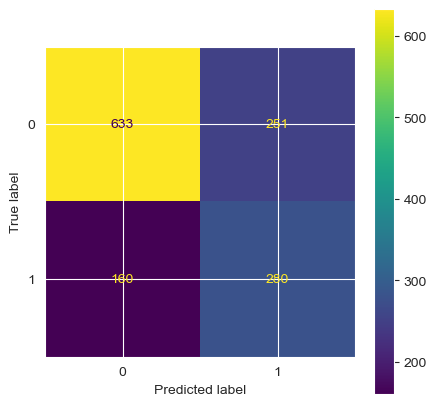

In [16]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=5)

X = df.drop(columns=['id', 'label', 'target'])
y = df.target

# Split data into training, dev and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.10, stratify=y, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

scaler = StandardScaler()

tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
#tfidf_char = TfidfVectorizer(ngram_range=(2, 2), analyzer='char', stop_words='english')
#count_vect = CountVectorizer(ngram_range=(1, 3), stop_words='english')

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
     (scaler, ['compound', 'neg', 'neu', 'pos']), # we scale numeric features
     (tfidf_vect, 'clean'),
#     (tfidf_char, 'clean'),
    remainder = 'drop')

dt_pipe = make_pipeline(preprocessor, dt_clf)

dt_pipe.fit(X_train, y_train)
y_val_pred = dt_pipe.predict(X_val)

print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred, labels=dt_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_pipe.classes_)

fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax);

#### 6.4 Random Forest

(11916, 6) (1324, 6) (11916,) (1324,)
              precision    recall  f1-score   support

           0       0.76      0.91      0.83       884
           1       0.70      0.41      0.51       440

    accuracy                           0.74      1324
   macro avg       0.73      0.66      0.67      1324
weighted avg       0.74      0.74      0.72      1324



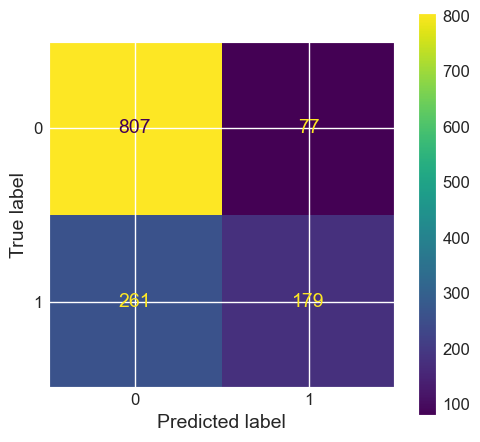

In [35]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')

X = df.drop(columns=['id', 'label', 'target'])
y = df.target

# Split data into training, dev and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.10, stratify=y, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

scaler = StandardScaler()

tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
#tfidf_char = TfidfVectorizer(ngram_range=(2, 2), analyzer='char', stop_words='english')
#count_vect = CountVectorizer(ngram_range=(1, 3), stop_words='english')

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
     (scaler, ['compound', 'neg', 'neu', 'pos']), # we scale numeric features
     (tfidf_vect, 'clean'),
#     (tfidf_char, 'clean'),
    remainder = 'drop')

rf_pipe = make_pipeline(preprocessor, rf_clf)

rf_pipe.fit(X_train, y_train)
y_val_pred = rf_pipe.predict(X_val)

print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred, labels=rf_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_pipe.classes_)

fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax);

###### 6.5 KNN

(11916, 6) (1324, 6) (11916,) (1324,)
              precision    recall  f1-score   support

           0       0.74      0.88      0.80       884
           1       0.61      0.40      0.48       440

    accuracy                           0.72      1324
   macro avg       0.68      0.64      0.64      1324
weighted avg       0.70      0.72      0.70      1324



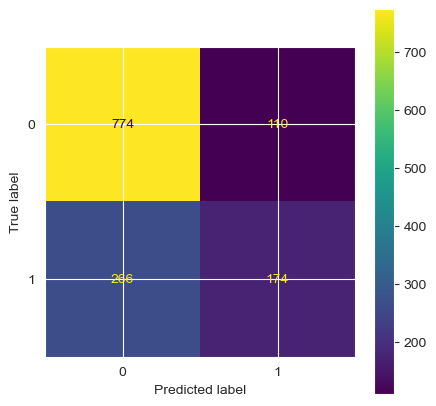

In [17]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(15)

X = df.drop(columns=['id', 'label', 'target'])
y = df.target

# Split data into training, dev and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.10, stratify=y, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

scaler = StandardScaler()

tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
#tfidf_char = TfidfVectorizer(ngram_range=(2, 2), analyzer='char', stop_words='english')
#count_vect = CountVectorizer(ngram_range=(1, 3), stop_words='english')

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
     (scaler, ['compound', 'neg', 'neu', 'pos']), # we scale numeric features
     (tfidf_vect, 'clean'),
#     (tfidf_char, 'clean'),
    remainder = 'drop')

knn_pipe = make_pipeline(preprocessor, knn_clf)

knn_pipe.fit(X_train, y_train)
y_val_pred = knn_pipe.predict(X_val)

print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred, labels=knn_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_pipe.classes_)

fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax);

#### 6.6 SVM

(11916, 6) (1324, 6) (11916,) (1324,)
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       884
           1       0.62      0.62      0.62       440

    accuracy                           0.75      1324
   macro avg       0.72      0.72      0.72      1324
weighted avg       0.75      0.75      0.75      1324



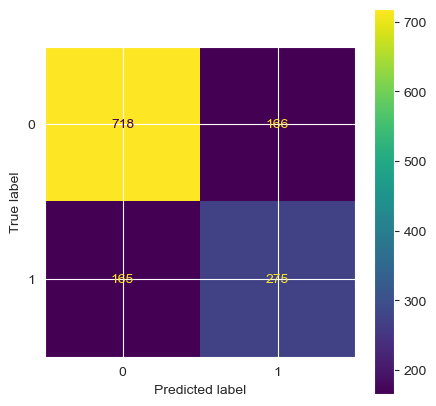

In [18]:
from sklearn.svm import LinearSVC # LinearSVC gave better results than regular SVM (with linear/rbf/poly kernel)

svm_clf = LinearSVC(random_state=42, class_weight='balanced', max_iter=3000) # max_iter=1500

X = df.drop(columns=['id', 'label', 'target'])
y = df.target

# Split data into training, dev and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.10, stratify=y, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

scaler = StandardScaler()

tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
#tfidf_char = TfidfVectorizer(ngram_range=(2, 2), analyzer='char', stop_words='english')
#count_vect = CountVectorizer(ngram_range=(1, 3), stop_words='english')

# We distribute the different columns to different preprocessing steps
preprocessor = make_column_transformer(
     (scaler, ['compound', 'neg', 'neu', 'pos']), # we scale numeric features
     (tfidf_vect, 'clean'),
#     (tfidf_char, 'clean'),
    remainder = 'drop')

svm_pipe = make_pipeline(preprocessor, svm_clf)

svm_pipe.fit(X_train, y_train)
y_val_pred = svm_pipe.predict(X_val)

print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred, labels=svm_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_pipe.classes_)

fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax);

### The above results tell us that SDGClassifer performs the best.

### 7. Fine-tune the best model (cross-validation with grid search)

In [19]:
# Take a look at the steps of the pipeline with SDGClassifier, so that we can work on the parameter grid
sdg_pipe.named_steps

{'columntransformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  ['compound', 'neg', 'neu', 'pos']),
                                 ('tfidfvectorizer',
                                  TfidfVectorizer(ngram_range=(1, 2),
                                                  stop_words='english'),
                                  'clean')]),
 'sgdclassifier': SGDClassifier(class_weight='balanced', random_state=42)}

In [22]:
X = df.drop(columns=['id', 'label', 'target'])
y = df.target

params = [{
    'columntransformer__tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (1, 4), (1, 6), (2, 7)],
    'sgdclassifier__loss': ['hinge', 'log'] # try different loss functions
    }]

gs = GridSearchCV(sdg_pipe, params, n_jobs=-1, cv=5, verbose=1, scoring='f1_macro')

# Feed it with the whole training data now (more data for a better training)
gs.fit(X, y)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['compound',
                                                                          'neg',
                                                                          'neu',
                                                                          'pos']),
                                                                        ('tfidfvectorizer',
                                                                         TfidfVectorizer(ngram_range=(1,
                                                                                                      2),
                                                                                         stop_words='english'),
                                                                         'clean')])),
                                       ('sgdclassifier',
                                        SGDClassifier(class_weight='balanced',
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid=[{'columntransformer__tfidfvectorizer__ngram_range': [(1,
                                                                               1),
                                                                              (1,
                                                                               2),
                                                                              (2,
                                                                               2),
                                                                              (1,
                                                                               3),
                                                                              (1,
                                                                               4),
                                                                              (1,
                                                                               6),
                                                                              (2,
                                                                               7)],
                          'sgdclassifier__loss': ['hinge', 'log']}],
             scoring='f1_macro', verbose=1)

In [23]:
print(gs.best_score_)  # top score
print(gs.best_params_) # best param settings -> GridSearch for hyper-parameter tuning once a model has been decided

0.7250339472394585
{'columntransformer__tfidfvectorizer__ngram_range': (1, 2), 'sgdclassifier__loss': 'hinge'}


In [31]:
# Output the parameters of the best estimator after grid search fine tune
best_estimator = gs.best_estimator_
best_estimator

# loss =’hinge’ is by default. Thus, it's not shown.

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['compound', 'neg', 'neu',
                                                   'pos']),
                                                 ('tfidfvectorizer',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'clean')])),
                ('sgdclassifier',
                 SGDClassifier(class_weight='balanced', random_state=42))])

### 8. Test the model's generalization

In [43]:
test_IN = pd.read_csv('test_IN.csv', delimiter=',', encoding='utf-8')
test_IN.head()

,id,tweet
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...
1,27014,"#ConstitutionDay is revered by Conservatives, ..."
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...
3,13876,#Watching #Boomer getting the news that she is...
4,60133,#NoPasaran: Unity demo to oppose the far-right...


In [44]:
test_IN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860 entries, 0 to 859
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      860 non-null    int64 
 1   tweet   860 non-null    object
dtypes: int64(1), object(1)
memory usage: 13.6+ KB


In [25]:
# Check for missing values
test_IN.isnull().sum()

id       0
tweet    0
dtype: int64

In [26]:
# Check for duplicates
test_IN.duplicated().sum()

0

In [45]:
# Clean the text
test_IN['clean'] = test_IN['tweet'].apply(lambda x: clean(x))

# Feature extraction > Preprocessing
test_IN['compound'] = [analyzer.polarity_scores(x)['compound'] for x in test_IN['tweet']]
test_IN['neg'] = [analyzer.polarity_scores(x)['neg'] for x in test_IN['tweet']]
test_IN['neu'] = [analyzer.polarity_scores(x)['neu'] for x in test_IN['tweet']]
test_IN['pos'] = [analyzer.polarity_scores(x)['pos'] for x in test_IN['tweet']]
test_IN.head()

,id,tweet,clean,compound,neg,neu,pos
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,whoisq wherestheserver dumpnike declasfisa dem...,-0.8260,0.288,0.638,0.075
1,27014,"#ConstitutionDay is revered by Conservatives, ...",constitutionday revered conservative hated pro...,-0.1531,0.223,0.532,0.245
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,foxnews nra maga potus trump ndamendment rnc u...,0.0000,0.000,1.000,0.000
3,13876,#Watching #Boomer getting the news that she is...,watching boomer getting news still parole alwa...,0.5719,0.000,0.810,0.190
4,60133,#NoPasaran: Unity demo to oppose the far-right...,nopasaran unity demo oppose far right london a...,0.0000,0.000,1.000,0.000


In [46]:
best_estimator.named_steps

{'columntransformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  ['compound', 'neg', 'neu', 'pos']),
                                 ('tfidfvectorizer',
                                  TfidfVectorizer(ngram_range=(1, 2),
                                                  stop_words='english'),
                                  'clean')]),
 'sgdclassifier': SGDClassifier(class_weight='balanced', random_state=42)}

In [47]:
# Have the sdg_pipeline to make prediction on the test set and save it as a new column in the test set
test_IN['target'] = best_estimator.predict(test_IN)
test_IN.head()

,id,tweet,clean,compound,neg,neu,pos,target
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,whoisq wherestheserver dumpnike declasfisa dem...,-0.8260,0.288,0.638,0.075,1
1,27014,"#ConstitutionDay is revered by Conservatives, ...",constitutionday revered conservative hated pro...,-0.1531,0.223,0.532,0.245,0
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,foxnews nra maga potus trump ndamendment rnc u...,0.0000,0.000,1.000,0.000,0
3,13876,#Watching #Boomer getting the news that she is...,watching boomer getting news still parole alwa...,0.5719,0.000,0.810,0.190,0
4,60133,#NoPasaran: Unity demo to oppose the far-right...,nopasaran unity demo oppose far right london a...,0.0000,0.000,1.000,0.000,0


In [49]:
# Map the label with the target
test_IN['label'] = test_IN.target.map({0 : 'NOT', 1: 'OFF'}) 
test_IN.head()

,id,tweet,clean,compound,neg,neu,pos,target,label
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,whoisq wherestheserver dumpnike declasfisa dem...,-0.8260,0.288,0.638,0.075,1,OFF
1,27014,"#ConstitutionDay is revered by Conservatives, ...",constitutionday revered conservative hated pro...,-0.1531,0.223,0.532,0.245,0,NOT
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,foxnews nra maga potus trump ndamendment rnc u...,0.0000,0.000,1.000,0.000,0,NOT
3,13876,#Watching #Boomer getting the news that she is...,watching boomer getting news still parole alwa...,0.5719,0.000,0.810,0.190,0,NOT
4,60133,#NoPasaran: Unity demo to oppose the far-right...,nopasaran unity demo oppose far right london a...,0.0000,0.000,1.000,0.000,0,NOT


In [50]:
# test_IN.to_csv('test_IN_with_prediction.csv', index=False)

#### Additional part of the Task A: Compare the prediction with the gold labels

In [60]:
best_estimator.classes_

array([0, 1], dtype=int64)

              precision    recall  f1-score   support

         NOT       0.86      0.89      0.87       620
         OFF       0.68      0.63      0.66       240

    accuracy                           0.82       860
   macro avg       0.77      0.76      0.76       860
weighted avg       0.81      0.82      0.81       860



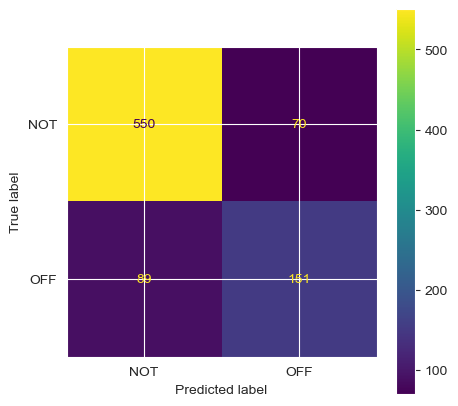

In [64]:
test_SET_gold = pd.read_csv('test_IN_gold.csv', delimiter=',', encoding='utf-8')
test_IN = pd.read_csv('test_IN_with_prediction.csv', delimiter=',', encoding='utf-8')

y_val1 = list(test_SET_gold.label)
y_val_pred1 = list(test_IN.label)

print(classification_report(y_val1, y_val_pred1))

cm = confusion_matrix(y_val1, y_val_pred1)

labels = ["NOT", "OFF"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(5,5))

disp.plot(ax=ax);